 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [44]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from tqdm import notebook

Скачаем обучающую и контрольную выборки.

In [45]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#classes = (<перечислите классы как строки>)

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [46]:
print(len(trainset))  # количество картинок в train
print(len(testset))   # количество картинок в test

60000
10000


In [47]:
# Проверим равномерное ли распределение объектов разных классов в train датасете
# Это можно сделать, посчитав количество объектов каждого класса
class_counts = {}
for _, label in trainset:
    if label not in class_counts:
        class_counts[label] = 1
    else:
        class_counts[label] += 1

print(class_counts)

{9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000}


In [48]:
pd_testset = pd.DataFrame(testset.targets.numpy())
for i in range(10):
  print('Class ', i, ': ', (pd_testset == i).sum())

Class  0 :  0    1000
dtype: int64
Class  1 :  0    1000
dtype: int64
Class  2 :  0    1000
dtype: int64
Class  3 :  0    1000
dtype: int64
Class  4 :  0    1000
dtype: int64
Class  5 :  0    1000
dtype: int64
Class  6 :  0    1000
dtype: int64
Class  7 :  0    1000
dtype: int64
Class  8 :  0    1000
dtype: int64
Class  9 :  0    1000
dtype: int64


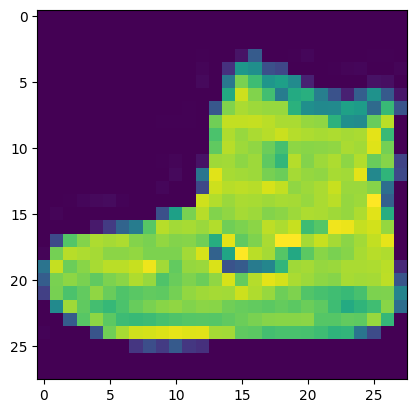

In [49]:
plt.imshow(trainset.data[0])

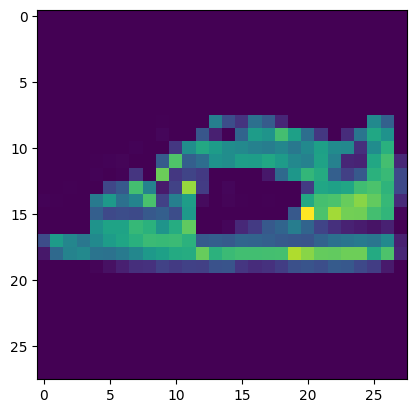

In [50]:
plt.imshow(trainset.data[13])

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-3
optimizer = torch.optim.SGD(MLP_net.parameters(), lr=learning_rate)
MLP_net.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # получение текущего батча
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # обнуление весов
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = MLP_net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # вывод текущего loss
        running_loss += loss.item()


        # вывод качества каждые 2000 батчей
        if i % 2000 == 1999:
            loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('END')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = MLP_net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print('\nOverall cccuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')